# ConvMixer

ConvMixer is similar to the Vision Transformer (and MLP-Mixer) in many respects: it directly operates on patches, it maintains an equal-resolution-and-size representation throughout all layers, it does no downsampling of the representation at successive layers, and it separates “channel-wise mixing” from the “spatial mixing” of information. But unlike the Vision Transformer and MLP-Mixer, ConvMixer does all these operations via only standard convolutions.

## Architecture

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F2050099%2F24d802b48e1a9fffde9f8313ad1b2635%2FCapture.PNG?generation=1658584828665394&alt=media)

* ConvMixer consists of a patch embedding layer followed by repeated applications of a simple fully-convolutional block. We maintain the spatial structure of the patch embeddings. Patch embeddings with patch size p and embedding dimension h can be implemented as convolution with cin input channels, h output channels, kernel size p, and stride p:
$$ z_{0} = BN (σ{Conv_{c_{in→h}}(X, stride=p, kernel_size=p)}) $$

* The ConvMixer block itself consists of depthwise convolution (i.e., grouped convolution with groups equal to the number of channels, h) followed by pointwise (i.e., kernel size 1 × 1) convolution. ConvMixers work best with unusually large kernel sizes for the depthwise convolution. Each of the convolutions is followed by an activation and post-activation BatchNorm:

$$ z'_{l} = BN (σ(ConvDepthwise(z_{l−1}))) + z_{l−1} $$

$$ z_{l+1} = BN (σ(ConvPointwise(z'_{l}))) $$

After many applications of this block, we perform global pooling to get a feature vector of size h, which we pass to a softmax classifier. 

ConvMixers are evaluated on ImageNet-1k classification data

## Paper
Patches Are All You Need? [2201.09792](https://arxiv.org/abs/2201.09792)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

170508288/170498071 [==============================] - 2s 0us/step
Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


# Data Preparation

In [3]:
image_size = 32
auto = tf.data.AUTOTUNE
batch_size = 128

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size), layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

2022-07-25 10:12:01.611384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 10:12:01.720187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 10:12:01.720977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 10:12:01.724019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Build the Model

In [4]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

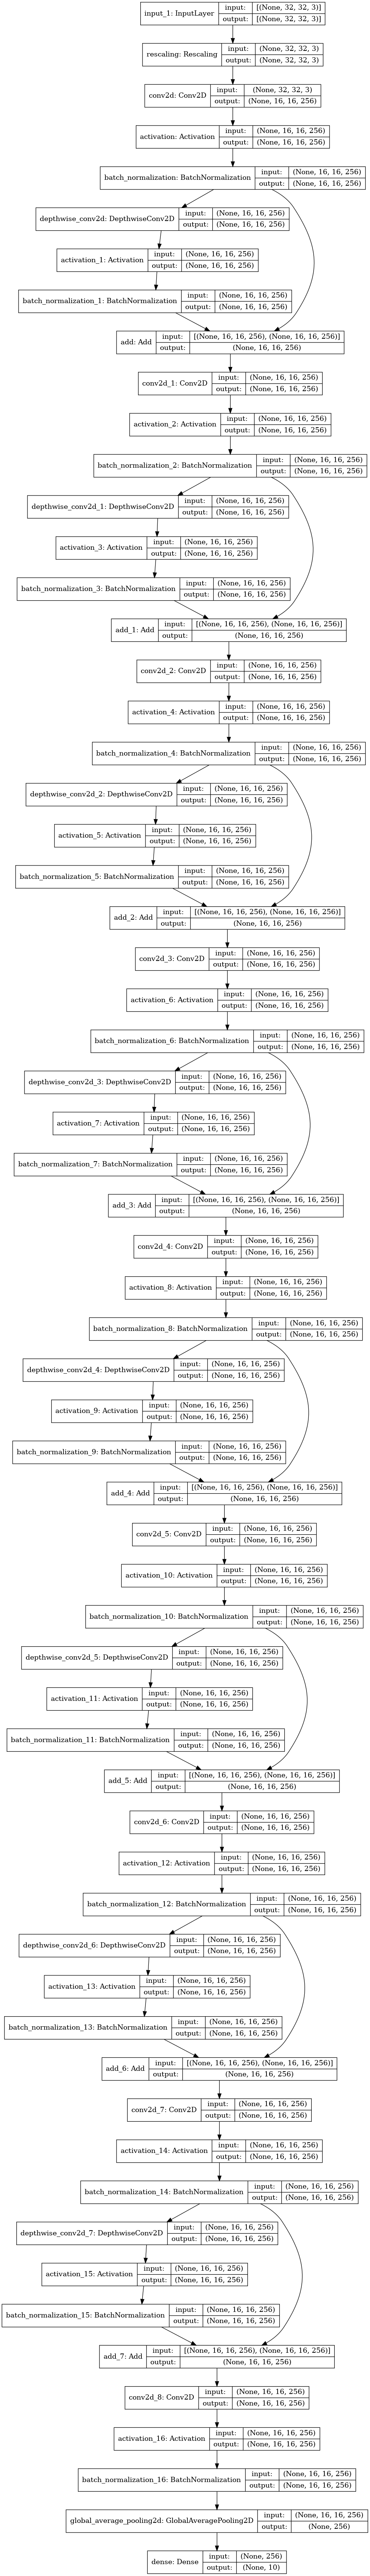

In [5]:
model = get_conv_mixer_256_8()
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Training

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)


early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)
_, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

2022-07-25 10:12:07.762978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-25 10:12:11.555508: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


352/352 [==============================] - 53s 125ms/step - loss: 1.2234 - accuracy: 0.5594 - val_loss: 3.8363 - val_accuracy: 0.1038
Epoch 2/100
352/352 [==============================] - 43s 123ms/step - loss: 0.7641 - accuracy: 0.7314 - val_loss: 0.9155 - val_accuracy: 0.6890
Epoch 3/100
352/352 [==============================] - 43s 123ms/step - loss: 0.5766 - accuracy: 0.7987 - val_loss: 0.7484 - val_accuracy: 0.7546
Epoch 4/100
352/352 [==============================] - 43s 123ms/step - loss: 0.4639 - accuracy: 0.8394 - val_loss: 0.5857 - val_accuracy: 0.8010
Epoch 5/100
352/352 [==============================] - 43s 123ms/step - loss: 0.3861 - accuracy: 0.8670 - val_loss: 0.5557 - val_accuracy: 0.8120
Epoch 6/100
352/352 [==============================] - 43s 123ms/step - loss: 0.3269 - accuracy: 0.8867 - val_loss: 0.6056 - val_accuracy: 0.8088
Epoch 7/100
352/352 [==============================] - 43s 123ms/step - loss: 0.2804 - accuracy: 0.9044 - val_loss: 0.5328 - val_accurac